## A Beer Garden-Based Segmentation of London's Boroughs

In [ ]:
!pip install geopy
!pip install bs4
!pip install uninstall folium
!pip install folium==0.5.0
!pip install -U numpy
!pip install pandas
!pip install scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn
#!pip install plotly
print('done!')

In [ ]:
import pandas as pd
import requests
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams.update({'font.size': 12})
import numpy as np
from bs4 import BeautifulSoup

print('done')

In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ed7503ad-3c61-4aa5-8293-e2ff908bc10a', project_access_token='p-f99948500d0e5d3f6b58422949ef8dc7122738de')
pc = project.project_context


## 1. Import [London Boroughs data](https://data.london.gov.uk/download/land-area-and-population-density-ward-and-borough/77e9257d-ad9d-47aa-aeed-59a00741f301/housing-density-borough.csv) from csv in webpage and develop dataframe

In [ ]:
# Date source 1. Save the sourcefile in a variable

London_df = pd.read_csv('housing-density-borough.csv', encoding = 'utf-8')
London_df.head()

In [ ]:
London_df.drop(London_df.columns[[0, 3, 6, 7, 8, 9]], axis = 1, inplace = True)
London_df.head()

In [ ]:
London_df = London_df[London_df.Year == 2021] # select 2021 data
London_df.head()

In [ ]:
London_df.drop(London_df.columns[[1]], axis = 1, inplace = True)
London_df.reset_index(drop=True, inplace = True)
London_df.head()

In [ ]:
London_df

In [ ]:
London_df['Name']

In [ ]:
London_df.drop(London_df.tail(3).index, inplace = True)

In [ ]:
print(London_df)

In [ ]:
London_df.rename({'Name': 'Borough'}, axis=1, inplace=True)

In [ ]:
London_df

## 2. Add demographic data re population of working age and alcohol drinkers

In [ ]:
# Data sources 2 and 3

df_data_2 = pd.read_csv('Working No Alcohol.csv', encoding = "utf-8")
df_data_2.head()

In [ ]:
London_merged = pd.merge(left=London_df, right=df_data_2, left_on='Borough', right_on='Borough')
London_merged

In [ ]:
London_merged.dtypes

In [ ]:
London_merged['Working_Age'] = London_merged['Working_Age'].str.strip('%').astype(float)
print(London_merged)
print(London_merged.dtypes)

In [ ]:
# Merging data sources 1 and 2

London_merged['No-Alcohol'] = London_merged['No_Alcohol'].str.strip('%').astype(float)
London_merged.head()

In [ ]:
London_merged.drop(['No_Alcohol'], axis=1, inplace=True)
London_merged.rename({'No-Alcohol': 'No_Alcohol'}, axis=1, inplace=True)
London_merged.head()

In [ ]:
# Source: 

London_merged.rename({'Inland_Area _Hectares': 'Area km2'}, axis=1, inplace=True)
London_merged['Area km2']=London_merged['Area km2']/100
London_merged.head()

In [ ]:
London_merged.rename({'Working_Age': 'Working_Age_%', 'No_Alcohol': 'Drinkers_%'}, axis=1, inplace=True)
London_merged.head()


In [ ]:
London_merged.dtypes

In [ ]:
London_merged['Drinkers_%']=100-London_merged['Drinkers_%']
London_merged['Drinkers_%']

In [ ]:
London_merged.head()

In [ ]:
London_merged['Drinkers_%'] = London_merged['Drinkers_%'].astype(int)
London_merged['Working_Age_%'] = London_merged['Working_Age_%'].astype(int)
London_merged.head()

In [ ]:
London_merged['Pub_Pop'] = London_merged['Population']*London_merged['Working_Age_%']/100*London_merged['Drinkers_%']/100
London_merged['Pub_Pop'] = London_merged['Pub_Pop'].astype(int)
London_merged.head()

In [ ]:
London_merged['Drinkers/km2'] = London_merged['Pub_Pop']/London_merged['Area km2'].astype(int)
London_merged['Drinkers/Pop %'] = 100*London_merged['Pub_Pop']/London_merged['Population'].astype(int)

In [ ]:
London_merged.head()

In [ ]:
London_merged['Drinkers/km2'] = London_merged['Drinkers/km2'].astype(int)
London_merged['Drinkers/Pop %'] = London_merged['Drinkers/Pop %'].astype(int)
London_merged['Area km2'] = round(London_merged['Area km2'],1)

London_merged.head()

In [ ]:
London_merged.to_csv('London_demogs.csv', index=False)

## 3. Scrape [Wikipedia page](https://en.wikipedia.org/wiki/List_of_areas_of_London) for neighbourhood-level info (for Foursquare API call)

In [ ]:
# Data source 3. Get the URL and save in a variable named html

URL = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
html = requests.get(URL).text

In [ ]:
# Parse the html into a BS object
soup = BeautifulSoup(html, 'html5lib')

In [ ]:
# Finding which table in the page contains the info we're looking for

tables = soup.find_all('table')
print(len(tables)) # How many tables are in the page?

In [ ]:
for index,table in enumerate(tables):
    if ("OS grid ref" in str(table)):
        table_index = index
print(table_index)

In [ ]:
# check table at index 1 is the one expected by inspecting the <th> headings

headings = tables[1].find_all("th")
headings

In [ ]:
London = pd.read_html(str(tables[1]), encoding = "ascii")[0]
print(len(London))
London.head()

In [ ]:
London = London.drop(columns=['Post town', 'Postcode district', 'Dial code', 'OS grid ref'])
London.head()

In [ ]:
headings = print(London.columns.tolist())

In [ ]:
London = London.drop(columns=['Post town', 'Postcode\xa0district', 'Dial\xa0code', 'OS grid ref'])
print(London.columns.tolist())

In [ ]:
London.columns=London.columns.str.replace('\xa0',' ')
print(London.columns.tolist())

In [ ]:
London.rename(columns={'Location': 'Neighbourhood', 'London borough': 'Borough'}, inplace=True)
print(London.columns.tolist())

In [ ]:
#London.rename(lambda col: col.replace('\xa0', ' '), axis='columns', inplace=True)
#print(London.columns.tolist())

In [ ]:
London.dtypes

In [ ]:
London['Neighbourhood']=London['Neighbourhood'].apply(str)
London['Borough']=London['Borough'].apply(str)

In [ ]:
London['Neighbourhood'].dtype

In [ ]:
for i in list(London.columns):
    print(type((London[i].iloc[1])))
    if isinstance(London[i].iloc[1], str):
        print("It is String")
    else:
        print('Not a String')

In [ ]:
London['Neighbourhood'] = London['Neighbourhood'].replace('Westminster','City of Westminster') # to correct a later geocoding error

In [ ]:
London.head(30)

In [ ]:
London.to_csv('hoods_boroughs_mapping.csv', index = False)

In [ ]:
hoods_boros = pd.read_csv('hoods_boroughs_mapping.csv', encoding = "ISO-8859-1")

In [ ]:
hoods_boros.head()

In [ ]:
hoods_boros['Neighbourhood'] = hoods_boros['Neighbourhood'].str.split('(').str[0].str.split(',').str[0].str.split('[').str[0].str.rstrip()
hoods_boros['Borough'] = hoods_boros['Borough'].str.split('(').str[0].str.split(',').str[0].str.split('[').str[0].str.rstrip()
hoods_boros.head()

In [ ]:
hoods_boros.to_csv('hoods_boroughs_mapping2.csv', index = False)

In [ ]:
hoods_boros = pd.read_csv('hoods_boroughs_mapping2.csv', encoding = "utf-8")

In [ ]:
hoods_list = hoods_boros['Neighbourhood'].tolist()
boros_list = hoods_boros['Borough'].tolist()

## 4. Add latitude and longitude to neighbourhoods using Geocoder Python package

In [ ]:
!pip install geocoder
import geocoder # import geocoder

In [ ]:
# Data source 4

latitudes_list = []
longitudes_list = []

for hood, boro in zip(hoods_list, boros_list):

    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}, Greater London'.format(hood, boro))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
        latitudes_list.append(latitude)
        longitudes_list.append(longitude)
        print(hood, boro, latitude, longitude)

# Define Lat/Long columns in the existing df and latitude/longitude lists as the source

hoods_boros['Latitude'] = latitudes_list
hoods_boros['Longitude'] = longitudes_list

In [ ]:
hoods_boros.to_csv('neighbourhoods_lat_lng3.csv', index=False)

In [ ]:
hoods_boros = pd.read_csv('neighbourhoods_lat_lng3.csv', encoding = "utf-8")

In [ ]:
hoods_boros.head()

In [ ]:
# drop neighbourhoods with same lat/Lng - keep the first

hoods_dropdups = hoods_boros.drop_duplicates(subset=['Latitude', 'Longitude'], keep='first')

In [ ]:
hoods_dropdups.to_csv('neighbourhoods_lat_lng4.csv', index=False)

In [ ]:
hoods_dropdups = pd.read_csv('neighbourhoods_lat_lng4.csv', encoding = "utf-8")

In [ ]:
hoods_dropdups.tail()

In [ ]:
headings = print(hoods_dropdups.columns.tolist())

## 5. Get neighbourhood venues using Foursquare venues/explore API request using neighbourhood lat/long coordinates

In [ ]:
# Define Foursquare credentials

CLIENT_ID = 'ID0DZJTPDZTM4SBOMXD1JRYOV1V1T5YAIQCYOBZ10TBUJJNU' # your Foursquare ID
CLIENT_SECRET = 'B2LI1HPVOGAEGMCL0MDGOI4DZ1NNIC5K41QDCGF3XCXT0GNW' # your Foursquare Secret
#ACCESS_TOKEN = 'NOFJZU04C3XDXGCFWG5LSAHTZGPGKFCDQXIT4F2ASHLKHKTM' # your FourSquare Access Token
VERSION = '20200604'
LIMIT = 100
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
# Define test API fields

categoryId = '4bf58dd8d48988d11b941735' #pubs
near = 'stoke newington, London, Greater London' #Borough
query = 'beer garden'
radius = '800' # 0.5 mile in metres
print('OK!')

## [Venues/explore](https://developer.foursquare.com/docs/api-reference/venues/explore/) 

In [ ]:
# testing the geocoder

apitesthood='acton'
g = geocoder.arcgis('acton, London, Greater London'.format(apitesthood))
stokie_coords = g.latlng
#radius = 800 # hard coded in this trial example. No radius specfied in the London-wide requests (Foursquare sets radius based on local density)
latitude = stokie_coords[0]
longitude = stokie_coords[1]
print(apitesthood, latitude, longitude)

In [ ]:
# Define API URL
from pandas import json_normalize

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, query, radius, LIMIT)
print(url)
results = requests.get(url).json()
items = results['response']['groups'][0]['items']
items
stokie_df = json_normalize(items) 
stokie_df.head()

In [ ]:
from random import randint
import time

### Get pubs in all neighbourhoods using auto radius (not specifying a radius variable)

In [ ]:
# Data source 5

def getHoodVenues(neighbourhoods, boroughs, latitudes, longitudes):
 
    venues_list=[]
    iter_list = []

    for hood, boro, lat, long in zip(neighbourhoods, boroughs, latitudes, longitudes):
        
# create the API request URL
    
        url = 'https://api.foursquare.com/v2/venues/explore?client_id=ID0DZJTPDZTM4SBOMXD1JRYOV1V1T5YAIQCYOBZ10TBUJJNU&client_secret=B2LI1HPVOGAEGMCL0MDGOI4DZ1NNIC5K41QDCGF3XCXT0GNW&ll={},{}&v=20200604&categoryId=4bf58dd8d48988d11b941735&query=beer garden&limit=100'.format(lat, long)
        time.sleep(2)
        
# make the GET request
        try:
            results_all = requests.get(url).json()['response']['groups'][0]['items']
        
        except:
            time.sleep(10)
            continue
                    
# return only relevant information for each nearby venue
    
        iter_list = [(hood,boro, lat, long, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['location']['formattedAddress']) for v in results_all]
        print(hood)
        venues_list.append(iter_list)
        #venues_list.append([(hood, lat, long, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['location']['formattedAddress'], v['venue']['categories'][0]['name']) for v in results])
        venues_list
        
    hood_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    hood_venues.columns = ['Neighbourhood', 'Borough', 'N_Lat', 'N_Long', 'Venue', 'V_Latitude', 'V_Longitude', 'V_Address']

    return(hood_venues)

In [ ]:
#london_venues = getHoodVenues(neighbourhoods=hoods_dropdups['Neighbourhood'], boroughs=hoods_dropdups['Borough'], latitudes=hoods_dropdups['Latitude'], longitudes=hoods_dropdups['Longitude'])
london_venues.to_csv('london_venues_no_radius.csv', encoding = "utf-8", index=False)

### ~ 49k venues in London - this is an overstatement caused by search radii 1) overlapping, resulting in duplicates across neighbourhoods and 2) returning out-of-London results

In [ ]:
london_venues = pd.read_csv('london_venues_no_radius.csv',encoding = 'utf-8')
london_venues.head()
print(london_venues.shape)

In [ ]:
london_venues.dtypes

### Remove duplicates by calculating distance of pub to duplicated neighbourhood centres and assigning the pub to the closest neighbourhood, and then delete instances of the same pub in other neighbourhoods

In [ ]:
london_venues['Distance'] = (1000*6371*3.14*2/360)*np.sqrt(np.square(london_venues['V_Latitude']-london_venues['N_Lat']) + np.square(london_venues['V_Longitude']-london_venues['N_Long']))

In [ ]:
london_venues.head()

In [ ]:
# sort by distance

london_venues = london_venues.sort_values('Distance', ascending=True)
london_venues.to_csv('venues_distance_sorted.csv', index=False)

In [ ]:
london_venues = pd.read_csv('venues_distance_sorted.csv', encoding="utf-8")

In [ ]:
london_venues.head()

### Dropping duplicates reduces the number of venues to 2594, though this still includes out-of-London results

In [ ]:
# Remove duplicate rows of venues caused by overlapping neighbourhood circles based on distance to neighbourhood centre

london_venues = london_venues.drop_duplicates(subset=['V_Address', 'Venue'], keep='first')
london_venues.to_csv('venues_distinct.csv', index=False)

In [ ]:
london_venues.shape # large decrease in results

In [ ]:
london_venues = pd.read_csv('venues_distinct.csv', encoding = "utf-8")

In [ ]:
london_venues.head()

In [ ]:
london_venues.drop(columns=['Neighbourhood', 'N_Lat','N_Long', 'V_Address','Distance'], inplace=True)
print(london_venues.columns.tolist())

In [ ]:
london_venues.to_csv('venues_distinct_no_rad.csv', index=False)

## 6. Correct for any inaccuracies in the Foursquare data and for out-of-London results using spatial join of pub coordinates and Borough polygons

### Firstly, understand the [London Boroughs geojsons](https://skgrange.github.io/data.html) and visualise the polygons 

In [ ]:
conda install geopandas

In [ ]:
import geopandas as gpd
import json

In [ ]:
# data source 6, https://skgrange.github.io/www/data/london_boroughs.json
# visualising the raw geojson with nested dictionary

with open('london_boroughs.json') as json_data:
    london_data = json.load(json_data)
london_data

In [ ]:
print(london_data['features'][0]['properties']['name'])
print(london_data['features'][0]['geometry']['coordinates'])

In [ ]:
# visualising the geojson direclty using geopandas

london_polygons = gpd.read_file('london_boroughs.json')
london_polygons.head()

In [ ]:
polygons = london_polygons[['name','geometry']]
polygons

In [ ]:
polygons.plot() # can plot from the derived polygons dataframe

In [ ]:
polygons['name'] = polygons['name'].replace('City of London','City')
polygons

### Then get the venues points/dataframe into the right format for the spatial join

In [ ]:
venues_points = pd.read_csv('venues_distinct_no_rad.csv', encoding ="utf-8")
venues_points.head()

In [ ]:
# create geodataframe of venues points, creating combined long/lat into one column

gdf_venues_points = gpd.GeoDataFrame(venues_points, geometry=gpd.points_from_xy(venues_points['V_Longitude'], venues_points['V_Latitude']))

In [ ]:
gdf_venues_points.head()

### Venues = 2230 after spatial join to correctly assign venues to Boroughs and remove out-of-London venues

In [ ]:
conda install Rtree

In [ ]:
# spatial-join - correct the Boroughs and remove out-of-London venues

gdf_venues_points.crs = polygons.crs
s_join_df = gpd.sjoin(gdf_venues_points, polygons, how='right',op="within").reset_index()

In [ ]:
print(s_join_df.shape)
s_join_df.head() # note new columns of name (correct Borough) geometry (Borough polygon)

In [ ]:
s_join_df.columns.tolist()

In [ ]:
# Remove most unnecessary columns (leave old Borough column for the moment for reference)

s_join_df.drop(columns=['index_right', 'index_left', 'geometry'], inplace=True)

In [ ]:
s_join_df.head()
print(s_join_df.columns.tolist())

In [ ]:
# Remove the old Borough column, rename 'name' to 'Borough' and move to first column

venues_final = s_join_df.drop(columns=['Borough'])
venues_final = venues_final[['name', 'Venue','V_Latitude', 'V_Longitude']]
venues_final.rename(columns={'name':'Borough'}, inplace=True)
venues_final = venues_final.sort_values(['Borough','Venue'],ascending=True).reset_index(drop=True)

venues_final.to_csv('venues_final.csv', index = False)
venues_final.head()

In [ ]:
boros_venues = []
boros_venues = venues_final.groupby('Borough').agg(Pubs=('Borough', 'count')).reset_index(drop=False)
boros_venues.to_csv('boros_venues.csv', index=False)
boros_venues

In [ ]:
print(boros_venues.columns.tolist())

## 7. Find the distance to the nearest venue (intra-Borough) for exploratory analysis and clustering

In [ ]:
venues = pd.read_csv('venues_final.csv', encoding = "utf-8")
venues.head()
print(venues.columns.tolist())

In [ ]:
# https://stackoverflow.com/questions/52820639/iterate-through-pandas-groups-of-coords-and-calculate-distances

from sklearn.neighbors import NearestNeighbors
import numpy as np

def distance(p1, p2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = p1
    lon2, lat2 = p2
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    metres = 1000*6371 * c
    return metres

boros = venues['Borough'].unique().tolist() # creating list of Boroughs to loop through
    
NN = [] # list of distance to nearest neighbour

for boro in boros:
    
    boro_xy = np.array(venues.loc[(venues['Borough'].isin([boro])), ['V_Longitude', 'V_Latitude']]) # creating np array of coords

    nbrs = NearestNeighbors(n_neighbors=2, metric=distance).fit(boro_xy)

    distances, indices = nbrs.kneighbors(boro_xy)
    result = distances[:, 1]
        
    for i in range(len(result)):
        print(boro, i, result[i])
        NN.append(result[i])

venues['NNeighbour'] = pd.DataFrame(NN).astype('int')

In [ ]:
venues.head()

In [ ]:
venues.to_csv('venues_NN.csv', index=False)

In [ ]:
venues = pd.read_csv('venues_NN.csv', encoding = "utf-8")

In [ ]:
#agg = venues[['Borough','NNeighbour']]
boros_NN = venues.groupby('Borough').agg(NN=('NNeighbour', 'mean')).astype('int').sort_values('NN', ascending=True).reset_index(drop=False)
print(boros_NN.columns.tolist())
boros_NN.to_csv('boros_NN_mean.csv', index=False)

In [ ]:
boros_NN

## Finding average distance between neighbours (intra-borough)

### This analysis and its outcome won't be presented in the final report the results aren't meaningful given that you'd expect average distance between pubs to increase as Borough area increases

In [ ]:
venues = pd.read_csv('venues_NN.csv', encoding = "utf-8")
venues.head()

In [ ]:
# https://stackoverflow.com/questions/42512346/python-average-distance-between-a-bunch-of-points-in-the-x-y-plane

from scipy.spatial.distance import pdist
import numpy as np

def compute_average_distance(X):
    """
    Computes the average distance among a set of n points in the d-dimensional space.

    Arguments:
        X {numpy array} - the query points in an array of shape (n,d), 
                          where n is the number of points and d is the dimension.
    Returns:
        {float} - the average distance among the points
    """
    return np.mean(pdist(X))


In [ ]:
ave_n = [] # list of ave distance between neighbours in a Borough

boros = venues['Borough'].unique().tolist() # creating list of Boroughs to loop through

for boro in boros:
    
    boro_xy = np.array(venues.loc[venues['Borough'].isin([boro]), ['V_Longitude','V_Latitude']]) # creating np array of coords for each Borough
    ave_dist = compute_average_distance(boro_xy)
    print(boro, ave_dist*1000*6371*2*3.14/360)
    ave_n.append([boro, round(ave_dist*1000*6371*2*3.14/360)])

venues_separation = pd.DataFrame(ave_n, columns = ['Borough', 'Ave dist'])
venues_separation

In [ ]:
ave_sep = venues_separation.reset_index(drop=True)
ave_sep.to_csv('venues_separation.csv', index=False)

In [ ]:
print(ave_sep.columns.tolist())

## 8 . Join the three venue-specific dataframes (which will then be joined with the demographic dataframe)

In [ ]:
boros_venues = pd.read_csv('boros_venues.csv', encoding = 'utf-8',index_col=[0])
boros_NN = pd.read_csv('boros_NN_mean.csv', encoding = 'utf-8',index_col=[0])
ave_sep = pd.read_csv('venues_separation.csv', encoding = 'utf-8',index_col=[0])

In [ ]:
boros_pubs_NN = pd.concat([boros_venues, boros_NN, ave_sep], axis=1).reset_index()
boros_pubs_NN['Borough'] = boros_pubs_NN['Borough'].replace('City','City of London')
boros_pubs_NN.to_csv('boros_pubs_NN.csv', index=False)
boros_pubs_NN

In [ ]:
print(boros_pubs_NN.columns.tolist())

### Combining geo-data with earlier demog-data

In [ ]:
demogs = pd.read_csv('London_demogs.csv', encoding = 'utf-8',index_col=[0])
boros_pubs_NN = pd.read_csv('boros_pubs_NN.csv', encoding = 'utf-8',index_col=[0])

In [ ]:
print(demogs.columns.tolist())
print(boros_pubs_NN.columns.tolist())

In [ ]:
demog_geo_data = pd.concat([demogs, boros_pubs_NN], axis=1).reset_index()
demog_geo_data.to_csv('geo_demog_data.csv', index=False)
demog_geo_data

In [ ]:
print(demog_geo_data.columns.tolist())

In [ ]:
demog_geo_data.rename(columns={'Pub_Pop': 'Drinkers'}, inplace=True)
demog_geo_data['Pubs/Area'] = (demog_geo_data['Pubs']/demog_geo_data['Area km2']).round(1)
demog_geo_data['Pop/Pub'] = (demog_geo_data['Population']/demog_geo_data['Pubs']).astype('int')
demog_geo_data['Drinkers/Pub'] = (demog_geo_data['Drinkers']/demog_geo_data['Pubs']).astype('int')
demog_geo_data.head()

In [ ]:
demog_geo_data.to_csv('demog_geo_data.csv', index=False)

In [ ]:
demog_geo_data.sort_values(['Borough'], ascending=True, inplace=True)
demog_geo_data.reset_index(drop=True)

In [ ]:
demog_geo_data.to_csv('demog_geo_data.csv', index=False)

In [ ]:
demog_geo_data = pd.read_csv('demog_geo_data.csv', encoding = 'utf-8')

In [ ]:
demog_geo_data.rename(columns={'Pubs/Area': 'Pubs/km2'}, inplace=True)

In [ ]:
# creating new column pop/km^2 which I will use in clustering later

demog_geo_data['Pop/km2'] = (demog_geo_data['Population']/demog_geo_data['Area km2']).astype('int')
demog_geo_data.head()

In [ ]:
dg_data = demog_geo_data.pop('Pop/km2')
demog_geo_data.insert(loc=3, column='Pop/km2', value=dg_data)
demog_geo_data.head()

In [ ]:
demog_geo_data.to_csv('demog_geo_data.csv', index=False)

### Reducing the number of variables by removing redundancy

In [ ]:
demog_geo_data = pd.read_csv('demog_geo_data.csv', encoding='utf-8')
clusdata_df = demog_geo_data.drop(columns=['Drinkers', 'Drinkers/Pop %', 'Drinkers/km2', 'Ave dist', 'Drinkers/Pub'])
clusdata_df

In [ ]:
print(clusdata_df.columns.tolist())

In [ ]:
exp_chart = clusdata_df[['Borough', 'Pubs', 'Pop/Pub']].sort_values('Pop/Pub', ascending = True)
exp_chart.set_index('Borough', drop=True, inplace=True)

ax =  exp_chart.plot.bar(y='Pop/Pub', ylabel='Pop/Pub (lower = better)', fontsize='large')
exp_chart.plot(y='Pubs', fontsize='large', c='k', ax=ax, use_index=False, secondary_y=True, mark_right=True)
ax.right_ax.set_ylabel('Pubs (higher = better)', fontsize='large')
ax.get_legend().set_bbox_to_anchor((0.6, 1))
for label in ax.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [ ]:
clusdata_df.describe().astype('int')

In [ ]:
clusdata_df.corr().round(2)

## 9. Clustering the Boroughs

In [ ]:
demog_geo_data = pd.read_csv('demog_geo_data.csv', encoding='utf-8')
clusdata_df = demog_geo_data.drop(columns=['Drinkers', 'Drinkers/Pop %', 'Drinkers/km2', 'Ave dist', 'Drinkers/Pub'])
clusdata_df.head()

In [ ]:
print(clusdata_df.columns.tolist())

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Data pre-processing/normalisation

In [ ]:
# Normalising the dataset

X = clusdata_df.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

### Determining the optimal k using the 'elbow method'

Ref https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_dataset)
    Sum_of_squared_distances.append(km.inertia_)

### Plotting the Sum of squares vs k suggests optimal k = 4 or 5. I'll use 5.

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
clusdata_df['Cluster'] = labels+1
clusdata_df.rename({'Cluster': 'Zone'}, axis=1, inplace=True)
clusdata_df

In [ ]:
df1 = clusdata_df.pop('Zone')
clusdata_df.insert(loc=0, column='Zone', value=df1)
clusdata_df

In [ ]:
clusdata_df['Zone'].replace({4:1, 5:4, 1:5}, inplace=True)
clusdata_df.head()

In [ ]:
clusdata_df.to_csv('clusdata_df.csv')

In [ ]:
clusdata_sorted_df = clusdata_df.sort_values(['Zone','Borough'], ascending=True).reset_index(drop=True)
clusdata_sorted_df.to_csv('clusdata_sorted_df.csv', encoding='utf-8')

clusdata_sorted_df

In [ ]:
print(clusdata_sorted_df.columns.tolist())

In [ ]:
cluster_results = clusdata_sorted_df.groupby('Zone').mean().round(1)
convert_dict = {'Population': int, 'Pop/km2': int, 'Working_Age_%': int, 'Drinkers_%':int, 'Pubs': int, 'NN':int, 'Pop/Pub':int}
cluster_results = cluster_results.astype(convert_dict)
cluster_results.to_csv('cluster_results.csv')

cluster_results

In [ ]:
print(cluster_results.columns.tolist())

In [ ]:
cluster_results.describe()

In [ ]:
# Add all Boroughs in single cell corresponding to cluster number

Zone1 = []
Zone2 = []
Zone3 = []
Zone4 = []
Zone5 = []

clus_boros = [Zone1, Zone2, Zone3, Zone4, Zone5]

for c, b in zip(clusdata_df['Zone'], clusdata_df['Borough']):
    if c == 1:
        Zone1.append(b)
    elif c == 2:
        Zone2.append(b)
    elif c == 3:
        Zone3.append(b)
    elif c == 4:
        Zone4.append(b)
    elif c == 5:
        Zone5.append(b)

cluster_results['Boroughs'] = clus_boros

cluster_results

In [ ]:
temp = cluster_results.pop('Boroughs')
cluster_results.insert(loc=0, column='Boroughs', value=temp)
cluster_results

In [ ]:
cluster_results['Boroughs'] = cluster_results['Boroughs'].astype('str')

In [ ]:
cluster_results['Boroughs'] = cluster_results['Boroughs'].str.replace(r'[^,\- a-zA-Z0-9]','')
cluster_results

In [ ]:
cluster_results.reset_index(drop=True)

In [ ]:
cluster_results.reset_index(drop=True, inplace=True)

In [ ]:
cluster_results

In [ ]:
print(cluster_results.columns.tolist())

In [ ]:
cluster_results.to_csv('cluster_summary2.csv')

In [ ]:
clusdata_df['Zone'].dtype

In [ ]:
boro_cluster_counts = clusdata_df['Zone'].value_counts().to_frame()
boro_cluster_counts.rename(columns={'Zone': 'B count'}, inplace=True)
boro_cluster_counts

In [ ]:
print(boro_cluster_counts.columns.tolist())

In [ ]:
boro_cluster_counts.index_col='Zone'
boro_cluster_counts

In [ ]:
cluster_summary = pd.merge(left=cluster_results, right=boro_cluster_counts, left_on='Zone', right_on='Zone', right_index=True)
cluster_summary

In [ ]:
print(cluster_summary.columns.tolist())

In [ ]:
clus = cluster_summary.pop('B count')
cluster_summary.insert(loc=2, column='B count', value=clus)
cluster_summary.reset_index()
cluster_summary.head()

In [ ]:
cluster_summary.to_csv('cluster_summary3.csv', index=False)

## 10. Visualising the clustering results

In [ ]:
import folium

print('Folium installed and imported!')

In [ ]:
clusdata_df = pd.read_csv('clusdata_df.csv', encoding = 'utf-8')
clusters_dict = []
clusters_dict = clusdata_df.set_index('Borough')['Zone']

london_map = folium.Map(location=[51.507222, -0.1275])

folium.GeoJson(
    london_data,
    style_function=lambda feature: {
     'fillColor': step(clusters_dict[feature['properties']['name']]),
        'color':'black',
        'weight': 2,
        'dashArray': '5, 5',
        'fillOpacity': 0.8,
    }
).add_to(london_map)

london_map

In [ ]:
# NOT USED AS NOT SUITABLE (STARTS AT 0) - define discrete colour bar for choropleth

import branca.colormap as cmp

step = cmp.StepColormap(
 ['purple', 'blue', 'green', 'orange', 'yellow'],
 vmin=0, vmax=5,
 caption='Clusters'
)
step

In [ ]:
# customised legend from https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Zone</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:purple;opacity:0.8;'></span>1</li>
    <li><span style='background:blue;opacity:0.8;'></span>2</li>
    <li><span style='background:green;opacity:0.8;'></span>3</li>
    <li><span style='background:orange;opacity:0.8;'></span>4</li>
    <li><span style='background:yellow;opacity:0.8;'></span>5</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

london_map.get_root().add_child(macro)

london_map

(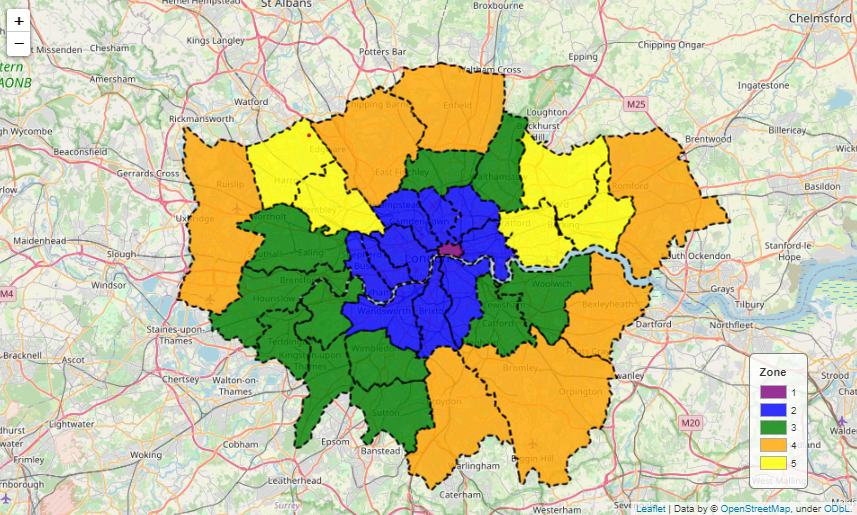)

In [ ]:
!pip install imgkit
!pip install selenium

## END!! Test code/experimentation follows ...

In [ ]:
print(clusdata_df['Borough'].dtype)
print(clusdata_df['Cluster'].dtype)

In [ ]:
clusdata_df[clusdata_df['Borough'] == 'Croydon']['Cluster']

In [ ]:
clusters_dict['Harrow']

In [ ]:
print(colormap)

In [ ]:
usa_polygons = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')
usa_polygons

In [ ]:
conda install -c plotly plotly

In [ ]:
import plotly.express as px

clusdata_sorted_df['Cluster'] = clusdata_sorted_df['Cluster'].astype('str')

df = clusdata_sorted_df
geojson = london_data

fig = px.choropleth(df, geojson=geojson, color="Cluster",
                    locations="Borough", featureidkey="properties.name",
                    projection="mercator", hover_data=['Cluster']
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()